<a href="https://colab.research.google.com/github/YuriiSulima/ML-models-for-CO2-Reduction/blob/main/Machine_Learning_Model_of_QDs_(GpyOpt)_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from sklearn import datasets
from sklearn.model_selection import cross_val_score
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Reading the dataset

In [ ]:
data = pd.read_csv("YS01 - Test Data.csv")
print(data.shape)

(103, 13)


# Preprocessing

In [ ]:
catalyst_encoder = LabelEncoder()
scavenger_encoder = LabelEncoder()

data.drop(['Index'],axis=1,inplace=True)
data.drop(['QDs'],axis=1,inplace=True)

data['Catalyst'] = catalyst_encoder.fit_transform(data['Catalyst'])
label_mapping = dict(zip(catalyst_encoder.classes_, catalyst_encoder.transform(catalyst_encoder.classes_)))
print(label_mapping)
data['Hole Scavengar'] = scavenger_encoder.fit_transform(data['Hole Scavengar'])
label_mapping = dict(zip(scavenger_encoder.classes_, scavenger_encoder.transform(scavenger_encoder.classes_)))
print(label_mapping)

# data['H2 Area'] = data['H2 Area'] / data['Time ']
# data['CH4 Area'] = data['CH4 Area'] / data['Time ']
# data['CO Area'] = data['CO Area'] / data['Time ']

# data.drop(['Time '],axis=1,inplace=True)

data = data.fillna(0)

features_scaler = StandardScaler()
target_scaler = StandardScaler()

data_pipeline = Pipeline([
        ('std_scaler', features_scaler),
    ])

target_pipeline = Pipeline([
        ('std_scaler', target_scaler),
    ])

target = data['CO Area']
features = data.drop('CO Area', axis=1)

columns_f = features.columns

features = data_pipeline.fit_transform(features)
features = pd.DataFrame(features,columns=columns_f)

target = data_pipeline.fit_transform(target.to_numpy().reshape(-1,1))
target = pd.DataFrame(target,columns=['CO Area'])


{'Co-TPP-COOH4': 0, 'CoCl2': 1, 'FeCl2': 2, 'FeCl3': 3, 'MnCl2': 4, 'ZnAc2': 5, 'ZnCl2': 6, nan: 7}
{'NaAsc': 0, nan: 1}


# Splitting the dataset

In [ ]:
x_train, X_test, y_train, Y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [ ]:
def objective_function(params):
    model = xgb.XGBRegressor(objective='reg:squarederror', params = params[0])
    scores = cross_val_score(model, x_train, y_train, cv=5,scoring ='r2')
    return np.mean(scores)

In [ ]:
bounds = [
    {'name': 'Catalyst', 'type': 'categorical', 'domain': [0,1,2,3,4,5,6]},
    {'name': 'Hole Scavenger (mM)', 'type': 'continuous', 'domain': (0, 1000)},
    {'name': 'Catalyst amount (umol)', 'type': 'continuous', 'domain': (0, 2000)},
    {'name': 'QD amount (umol)', 'type': 'continuous', 'domain': (0, 1000)},
    {'name': 'pH before', 'type': 'continuous', 'domain': (0, 14)},
    {'name': 'C', 'type': 'continuous', 'domain': (0.1, 10)},
    {'name': 'gamma', 'type': 'continuous', 'domain': (0.0001, 1)},
    {'name': 'n_estimators', 'type': 'discrete', 'domain': (10, 50, 100, 150, 200,300)},
    {'name': 'max_features', 'type': 'discrete', 'domain': (1, 2, 3, 4,5,10)},
    {'name': 'min_samples_split', 'type': 'discrete', 'domain': (2, 5, 10, 15, 20,30)}
]


In [ ]:
def run_optimization(acquisition_type):
    optimizer = GPyOpt.methods.BayesianOptimization(
        f=objective_function,
        domain=bounds,
        acquisition_type=acquisition_type
    )
    optimizer.run_optimization(max_iter=20)
    return optimizer

optimizers = {
    'Expected Improvement (EI)': run_optimization('EI'),
    'Lower Confidence Bound (LCB)': run_optimization('LCB'),
    'Maximum Probability of Improvement (MPI)': run_optimization('MPI')
}


In [ ]:
# Evaluate the best parameters found by each optimizer
results = {}
for name, optimizer in optimizers.items():
    best_params = optimizer.X[np.argmin(optimizer.Y)]
    best_params_dict = {
        'Catalyst':int(best_params[0]),
        'Hole Scavenger (mM)':int(best_params[1]),
        'Catalyst amount (umol)':int(best_params[2]),
        'QD amount (umol)':int(best_params[3]),
        'pH before':(best_params[4]),
        'C':(best_params[5]),
        'gamma':(best_params[6]),
        'n_estimators': int(best_params[7]),
        'max_features': int(best_params[8]),
        'min_samples_split': int(best_params[9])
    }

    # Train the final model with the best parameters
    final_model = xgb.XGBRegressor(objective='reg:squarederror', params = best_params[0])
    final_model.fit(x_train, y_train)
    final_accuracy = final_model.score(X_test, Y_test)

    results[name] = {
        'Best Parameters': best_params_dict,
        'Test Accuracy': final_accuracy
    }

# Print the results
for name, result in results.items():
    print(f"{name}:")
    print(f"  Best Parameters: {result['Best Parameters']}")
    print(f"  Test Accuracy: {result['Test Accuracy']:.4f}\n")


Expected Improvement (EI):
  Best Parameters: {'Catalyst': 3, 'Hole Scavenger (mM)': 737, 'Catalyst amount (umol)': 1690, 'QD amount (umol)': 236, 'pH before': 0.573095807815204, 'C': 4.4087450379549, 'gamma': 0.7523546204426079, 'n_estimators': 200, 'max_features': 3, 'min_samples_split': 30}
  Test Accuracy: 0.6096

Lower Confidence Bound (LCB):
  Best Parameters: {'Catalyst': 3, 'Hole Scavenger (mM)': 612, 'Catalyst amount (umol)': 919, 'QD amount (umol)': 296, 'pH before': 9.6184303261001, 'C': 8.04949555271594, 'gamma': 0.7344076985611782, 'n_estimators': 50, 'max_features': 10, 'min_samples_split': 30}
  Test Accuracy: 0.6096

Maximum Probability of Improvement (MPI):
  Best Parameters: {'Catalyst': 0, 'Hole Scavenger (mM)': 170, 'Catalyst amount (umol)': 1115, 'QD amount (umol)': 73, 'pH before': 4.61483586884324, 'C': 8.255475195215094, 'gamma': 0.7505570406599809, 'n_estimators': 100, 'max_features': 3, 'min_samples_split': 20}
  Test Accuracy: 0.6096



Iteration 1
  Best Parameters: {'Catalyst': 6, 'Hole Scavenger (mM)': 821, 'Catalyst amount (umol)': 1128, 'QD amount (umol)': 977, 'pH before': 11.440317982883727, 'C': 4.021545064902978, 'gamma': 0.25921646731927256, 'n_estimators': 300, 'max_features': 2, 'min_samples_split': 2}
  Test R²: 0.5887

Iteration 2
  Best Parameters: {'Catalyst': 6, 'Hole Scavenger (mM)': 995, 'Catalyst amount (umol)': 1163, 'QD amount (umol)': 387, 'pH before': 4.768050069583077, 'C': 4.106301471949529, 'gamma': 0.21062809786850512, 'n_estimators': 300, 'max_features': 10, 'min_samples_split': 2}
  Test R²: 0.6121

Iteration 3
  Best Parameters: {'Catalyst': 6, 'Hole Scavenger (mM)': 138, 'Catalyst amount (umol)': 1127, 'QD amount (umol)': 307, 'pH before': 2.5379913147205686, 'C': 4.881059574703658, 'gamma': 0.520566157517999, 'n_estimators': 100, 'max_features': 5, 'min_samples_split': 20}
  Test R²: 0.3672

Iteration 4
  Best Parameters: {'Catalyst': 1, 'Hole Scavenger (mM)': 123, 'Catalyst amount (um

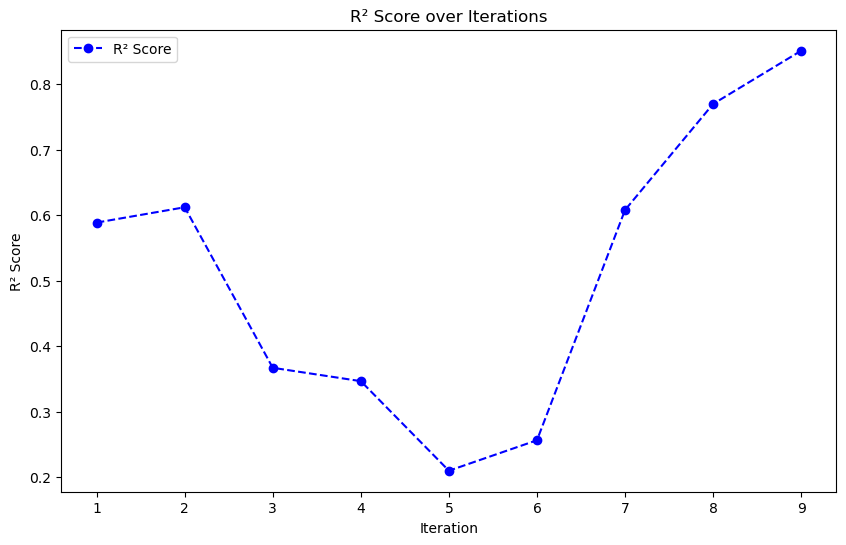

In [ ]:
X_pool, y_pool = x_train, y_train
X_rest, y_rest = X_test, Y_test
n_iterations = 10
acquisition_function = 'MPI'

# Store R² scores for each iteration
r2_scores = []
for iteration in range(n_iterations):
    print(f"Iteration {iteration + 1}")

    # Perform Bayesian optimization to suggest the next parameters to test
    optimizer = run_optimization(acquisition_function)
    best_params = optimizer.X[np.argmin(optimizer.Y)]
    best_params_dict = {
        'Catalyst':int(best_params[0]),
        'Hole Scavenger (mM)':int(best_params[1]),
        'Catalyst amount (umol)':int(best_params[2]),
        'QD amount (umol)':int(best_params[3]),
        'pH before':(best_params[4]),
        'C':(best_params[5]),
        'gamma':(best_params[6]),
        'n_estimators': int(best_params[7]),
        'max_features': int(best_params[8]),
        'min_samples_split': int(best_params[9])
    }

    # Simulate testing the suggested parameters (here we use the rest of the data for simulation)
    new_X, X_rest, new_y, y_rest = train_test_split(X_rest, y_rest, train_size=3, random_state=42)
    X_pool = np.vstack((X_pool, new_X))
    y_pool = np.vstack((y_pool, new_y))

    # Train the final model with the best parameters found
    final_model = xgb.XGBRegressor(objective='reg:squarederror', params = best_params)
    final_model.fit(X_pool, y_pool)

    # Predict on new instances
    new_instances_prediction = final_model.predict(new_X)
    new_instances_prediction = new_instances_prediction.reshape(-1, 1)
    # Use the predicted values to create new training instances
    X_pool = np.vstack((X_pool, new_X))
    y_pool = np.vstack((y_pool, new_instances_prediction))

    # Retrain the model with the new instances
    final_model.fit(X_pool, y_pool)
    final_r2 = final_model.score(X_rest, y_rest)
    r2_scores.append(final_r2)
    print(f"  Best Parameters: {best_params_dict}")
    print(f"  Test R²: {final_r2:.4f}\n")

# Plot the R² scores
print(X_pool.shape)
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), r2_scores, 'o--', color='b', label='R² Score')
plt.xlabel('Iteration')
plt.ylabel('R² Score')
plt.title('R² Score over Iterations')
plt.legend()
plt.show()

In [ ]:
optimizer = BayesianOptimization(params = best_params,f=objective_function, domain=bounds)

In [ ]:
optimizer.run_optimization(max_iter=50)

In [ ]:
optimized_params = optimizer.X[np.argmin(optimizer.Y)]
optimized_score = -np.min(optimizer.Y)

print(f"Catalyst: = {optimized_params[0]}, Hole Scavenger (mM): = {optimized_params[1]}, Catalyst Amount (umol): = {optimized_params[2]}")
print(f"QD amount (umol): = {optimized_params[3]}, pH before: = {optimized_params[4]}")
print(f"C: = {optimized_params[5]}, gamma: = {optimized_params[6]}")
print(f"Best cross-validated accuracy: {optimized_score}")

Catalyst: = 2.0, Hole Scavenger (mM): = 283.1822013877532, Catalyst Amount (umol): = 900.883946997073
QD amount (umol): = 9.929385854447027, pH before: = 3.58654908079132
C: = 0.9367954819255815, gamma: = 0.027449596075029243
Best cross-validated accuracy: -0.4881499056760257


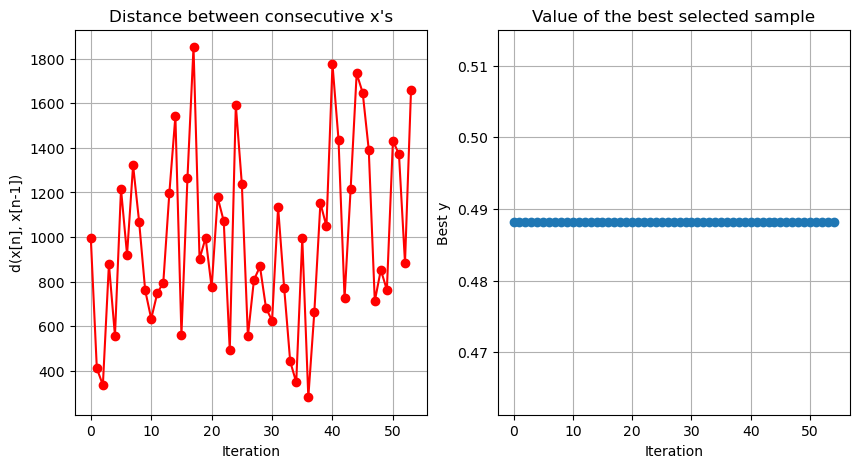

In [ ]:
optimizer.plot_convergence()